In [260]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
from matplotlib.font_manager import FontProperties

from collections import defaultdict

In [261]:
def gaussian(x, mean, std_dev):
    return (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)

In [262]:
def find_gaussian_range(mean, std_dev, threshold=0.01):
    """Find the x-range for the Gaussian function to reach the y-value threshold."""
    low_x = mean - np.sqrt(-2 * std_dev**2 * np.log(std_dev * np.sqrt(2 * np.pi) * threshold))
    high_x = mean + np.sqrt(-2 * std_dev**2 * np.log(std_dev * np.sqrt(2 * np.pi) * threshold))
    return low_x, high_x

In [263]:
def plot_gaussian_distribution(dataframe, model_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    min_support_values = dataframe['Minimum Support'].unique()
    colors = cm.viridis(np.linspace(0, 1, len(min_support_values)))

    for idx, (min_support, group) in enumerate(dataframe.groupby('Minimum Support')):
        std_dev = group['Match Percentage'].std()
        mean_match_percentage = dataframe[dataframe['Minimum Support'] == min_support]['Match Percentage'].mean()

        if np.isnan(std_dev):
            continue

        x = np.linspace(0, 100, 1000)
        y = gaussian(x, mean_match_percentage, std_dev)

        color = colors[idx % len(colors)]
        ax.plot(x, y, label=f'Support range: {min_support} : {min_support + 20}')
        ax.fill_between(x, y, color=color, alpha=0.1)

    ax.set_title(f'Gaussian Distribution of Equation Match Percentage for {model_name}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel('Equation Match Percentage')
    ax.set_ylabel('Probability Density')

    return fig

In [264]:
def plot_gaussian_distribution_multiple_models(dataframe, modelname_visible=False):
    fig = plt.figure(figsize=(14, 5))  # Reduce the height of the figure
    gs = GridSpec(1, 2, width_ratios=[3, 1])  # Create grid with space for legend
    ax = fig.add_subplot(gs[0])  # Create main plot area

    models = dataframe['Model'].unique()
    unique_combinations = dataframe.drop_duplicates(subset=['Model', 'Minimum Support'])
    num_lines = len(unique_combinations)
    colors = cm.viridis(np.linspace(0, 1, num_lines))  # Generate a global color map

    # Determine the global x-range
    global_low_x = float('inf')
    global_high_x = float('-inf')
    
    for model_name in models:
        model_data = dataframe[dataframe['Model'] == model_name]
        for min_support in model_data['Minimum Support'].unique():
            group = model_data[model_data['Minimum Support'] == min_support]
            if group.empty:
                continue
            std_dev = group['Match Percentage'].std()
            mean_match_percentage = group['Match Percentage'].mean()
            if np.isnan(std_dev):
                continue
            low_x, high_x = find_gaussian_range(mean_match_percentage, std_dev)
            global_low_x = min(global_low_x, low_x)
            global_high_x = max(global_high_x, high_x)
    
    x = np.linspace(global_low_x, global_high_x, 1000)
    color_idx = 0
    legend_handles = defaultdict(list)
    legend_labels = defaultdict(list)
    annotations = []

    for model_name in models:
        model_data = dataframe[dataframe['Model'] == model_name]

        for min_support in model_data['Minimum Support'].unique():
            group = model_data[model_data['Minimum Support'] == min_support]
            if group.empty:
                continue
            
            std_dev = group['Match Percentage'].std()
            mean_match_percentage = group['Match Percentage'].mean()

            if np.isnan(std_dev):
                continue

            y = gaussian(x, mean_match_percentage, std_dev)

            color = colors[color_idx]
            color_idx += 1
            line, = ax.plot(x, y, color=color, label=f'Support range: {min_support} : {min_support + 20}')
            ax.fill_between(x, y, color=color, alpha=0.1)
            legend_handles[model_name].append(line)
            legend_labels[model_name].append(f'Support range: {min_support} : {min_support + 20}')
            
            if modelname_visible:
                # Annotate the peak of the Gaussian curve with the model name
                peak_y = max(y)
                annotations.append((mean_match_percentage, peak_y, model_name, color))

    if modelname_visible:
        # Adjust annotations to avoid overlap
        annotations.sort(key=lambda x: x[1], reverse=True)  # Sort by y-value (peak height)
        offset = 0.05  # Offset value for text
        adjusted_annotations = []
        for i, (x, y, model_name, color) in enumerate(annotations):
            adjusted_y = y
            if i > 0 and abs(y - adjusted_annotations[-1][1]) < offset:
                # Check both directions for the best adjustment
                if adjusted_y - offset > 0 and (i == 1 or abs((adjusted_y - offset) - adjusted_annotations[-2][1]) >= offset):
                    adjusted_y -= offset
                else:
                    adjusted_y += offset
            adjusted_annotations.append((x, adjusted_y, model_name, color))
            ax.text(x, adjusted_y, model_name, color=color, ha='center', va='bottom', fontproperties=FontProperties(weight='bold'))

    ax.set_title('Gaussian Distribution of Equation Match Percentage for Various Models')
    ax.set_xlabel('Equation Match Percentage')
    ax.set_ylabel('Probability Density')
    
    # Custom legend handling
    legend_entries = []
    bold_font = FontProperties(weight='bold')  # Define bold font properties
    for model_name in models:
        legend_entries.append((plt.Line2D([0], [0], color='white', lw=0), model_name))
        for handle, label in zip(legend_handles[model_name], legend_labels[model_name]):
            legend_entries.append((handle, label))

    legend_ax = fig.add_subplot(gs[1])  # Create space for legend
    legend_ax.axis('off')  # Hide the legend subplot axis

    # Create custom legend entries
    handles = []
    labels = []
    for entry in legend_entries:
        if entry[1] in models:
            # Add bold text for model names
            handles.append(entry[0])
            labels.append(entry[1])
        else:
            handles.append(entry[0])
            labels.append(entry[1])

    # Add the legend with custom properties
    custom_legend = legend_ax.legend(handles, labels, loc='upper left', frameon=False)
    for text in custom_legend.get_texts():
        if text.get_text() in models:
            text.set_fontproperties(bold_font)  # Apply bold font to model names

    fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit everything nicely and reduce right padding
    return fig


In [265]:
def plot_mean_match_percentage(evaluation_summary):
    filtered_df = evaluation_summary[
        (evaluation_summary['Minimum Support'].between(-30, 10)) & 
        ((evaluation_summary['Maximum Support'] - evaluation_summary['Minimum Support']) == 20)
    ]

    mean_match_percentages = filtered_df.groupby(['Minimum Support', 'Model'])['Match Percentage'].mean().reset_index()

    fig, ax = plt.subplots(figsize=(10, 6))

    for model in mean_match_percentages['Model'].unique():
        model_data = mean_match_percentages[mean_match_percentages['Model'] == model]
        ax.plot(model_data['Minimum Support'], model_data['Match Percentage'], label=model)

    def format_x_axis(value, tick_number):
        return f'{value}:{value + 20}'
    
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_x_axis))

    ax.set_xlabel('Support (minimum : maximum)')
    ax.set_ylabel('Mean Match Percentage')
    ax.set_title('Mean Match Percentage for Different Models')
    ax.legend()

    return fig

In [266]:
evaluation_path = '../evaluation/'
evaluation_summary_path = f'{evaluation_path}evaluation_summary.csv'

evaluation_summary = pd.read_csv(evaluation_summary_path)

In [267]:
evaluation_summary.head()

,Model,Dataset,Skeleton Encoder Layers,Loss Version,Minimum Support,Maximum Support,Total Entries,Match Sum,Match Percentage
0,mmsr,train_nc,NaN,NaN,-30,-10,228,17,7.456140
1,mmsr,train_nc,NaN,NaN,-29,-9,228,11,4.824561
2,mmsr,train_nc,NaN,NaN,-28,-8,228,14,6.140351
3,mmsr,train_nc,NaN,NaN,-27,-7,229,20,8.733624
4,mmsr,train_nc,NaN,NaN,-26,-6,230,24,10.434783


In [268]:
evaluation_summary['Model'].unique()

array(['mmsr', 'mmsr_se1_oldloss', 'mmsr_se5_newloss', 'mmsr_se5_oldloss',
       'nsr'], dtype=object)

In [269]:
mmsr_newloss_eval = evaluation_summary[evaluation_summary['Model'] == 'mmsr_se5_newloss']
mmsr_newloss_eval.head()

,Model,Dataset,Skeleton Encoder Layers,Loss Version,Minimum Support,Maximum Support,Total Entries,Match Sum,Match Percentage
43,mmsr_se5_newloss,train_nc,5.0,new,-24,-4,234,43,18.376068
44,mmsr_se5_newloss,train_nc,5.0,new,-24,-4,233,45,19.313305
45,mmsr_se5_newloss,train_nc,5.0,new,-24,-4,234,42,17.948718
46,mmsr_se5_newloss,train_nc,5.0,new,-24,-4,234,43,18.376068
47,mmsr_se5_newloss,train_nc,5.0,new,-24,-4,232,44,18.965517


In [270]:
#TO CHANGE: % 20 so values never get sampled from the same range
evaluation_summary[(evaluation_summary['Model'] == 'mmsr_se5_newloss') & (evaluation_summary['Minimum Support'] % 10 == 0)]

,Model,Dataset,Skeleton Encoder Layers,Loss Version,Minimum Support,Maximum Support,Total Entries,Match Sum,Match Percentage
83,mmsr_se5_newloss,train_nc,5.0,new,-20,0,243,78,32.098765
84,mmsr_se5_newloss,train_nc,5.0,new,-20,0,244,82,33.606557
85,mmsr_se5_newloss,train_nc,5.0,new,-20,0,243,78,32.098765
86,mmsr_se5_newloss,train_nc,5.0,new,-20,0,244,81,33.196721
87,mmsr_se5_newloss,train_nc,5.0,new,-20,0,243,73,30.041152
88,mmsr_se5_newloss,train_nc,5.0,new,-20,0,244,78,31.967213
89,mmsr_se5_newloss,train_nc,5.0,new,-20,0,243,81,33.333333
90,mmsr_se5_newloss,train_nc,5.0,new,-20,0,245,76,31.020408
91,mmsr_se5_newloss,train_nc,5.0,new,-20,0,244,88,36.065574
92,mmsr_se5_newloss,train_nc,5.0,new,-20,0,244,79,32.377049


In [271]:
evaluation_summary[(evaluation_summary['Model'] == 'mmsr_se5_newloss') & (evaluation_summary['Minimum Support'] % 10 == 0)].to_csv('temp.csv')

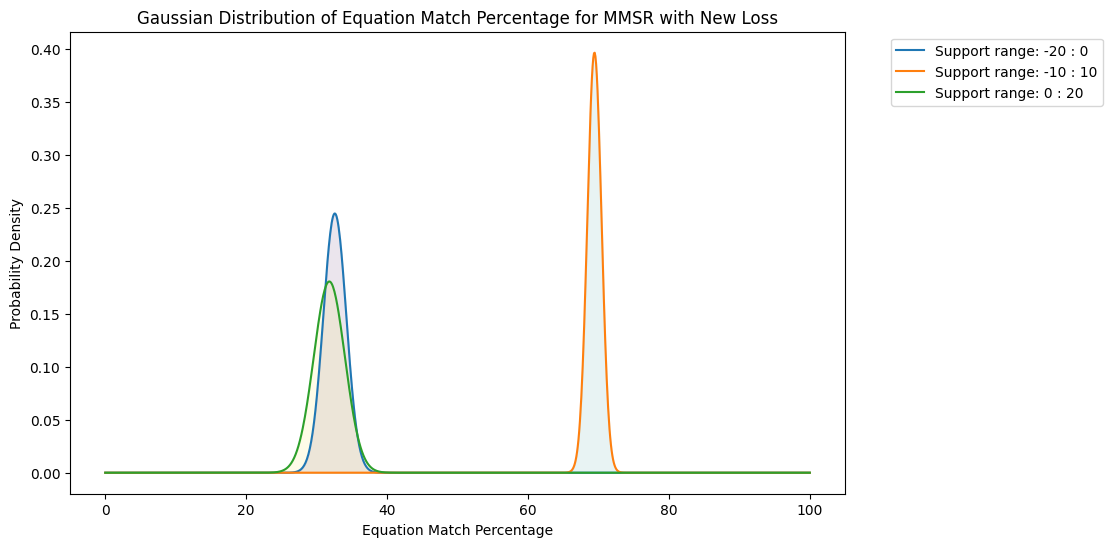

In [272]:
fig = plot_gaussian_distribution(evaluation_summary[(evaluation_summary['Model'] == 'mmsr_se5_newloss') & (evaluation_summary['Minimum Support'] % 10 == 0)], 'MMSR with New Loss')
fig.show()

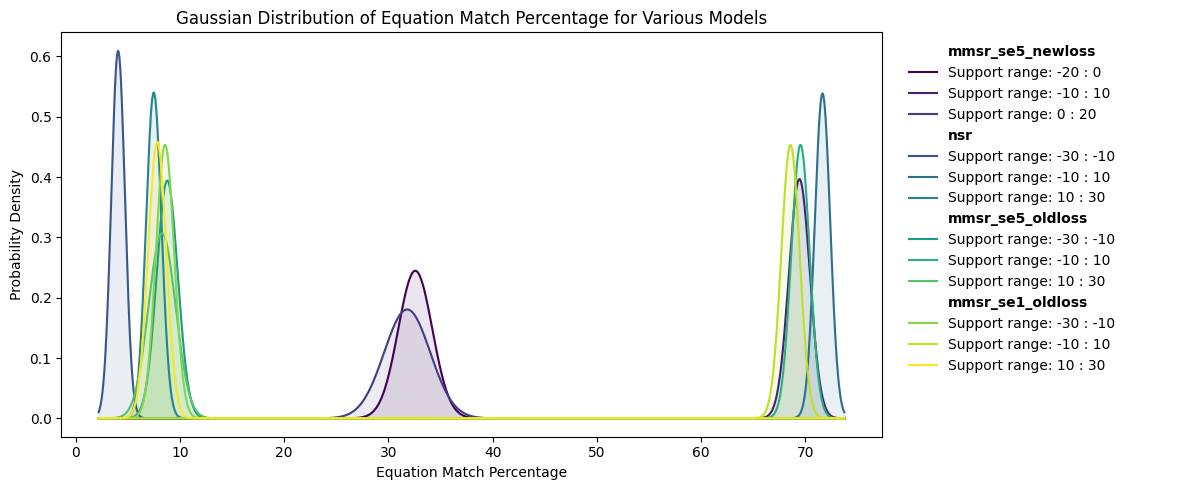

In [273]:
mmsr_se5_newloss = evaluation_summary[(evaluation_summary['Model'] == 'mmsr_se5_newloss') & (evaluation_summary['Minimum Support'] % 10 == 0) & (evaluation_summary['Minimum Support'].between(-30, 10))]
mmsr_se5_oldloss = evaluation_summary[(evaluation_summary['Model'] == 'mmsr_se5_oldloss') & (evaluation_summary['Minimum Support'] % 10 == 0) & (evaluation_summary['Minimum Support'].between(-30, 10))]
nsr = evaluation_summary[(evaluation_summary['Model'] == 'nsr') & (evaluation_summary['Minimum Support'] % 10 == 0) & (evaluation_summary['Minimum Support'].between(-30, 10))]
mmsr_se1_oldloss = evaluation_summary[(evaluation_summary['Model'] == 'mmsr_se1_oldloss') & (evaluation_summary['Minimum Support'] % 10 == 0) & (evaluation_summary['Minimum Support'].between(-30, 10))]

all_models = pd.concat([
    mmsr_se5_newloss,
    nsr,
    mmsr_se5_oldloss,
    mmsr_se1_oldloss
])

#TO DELETE
all_models = pd.read_csv('temp2.csv')

fig = plot_gaussian_distribution_multiple_models(all_models)
fig.show()

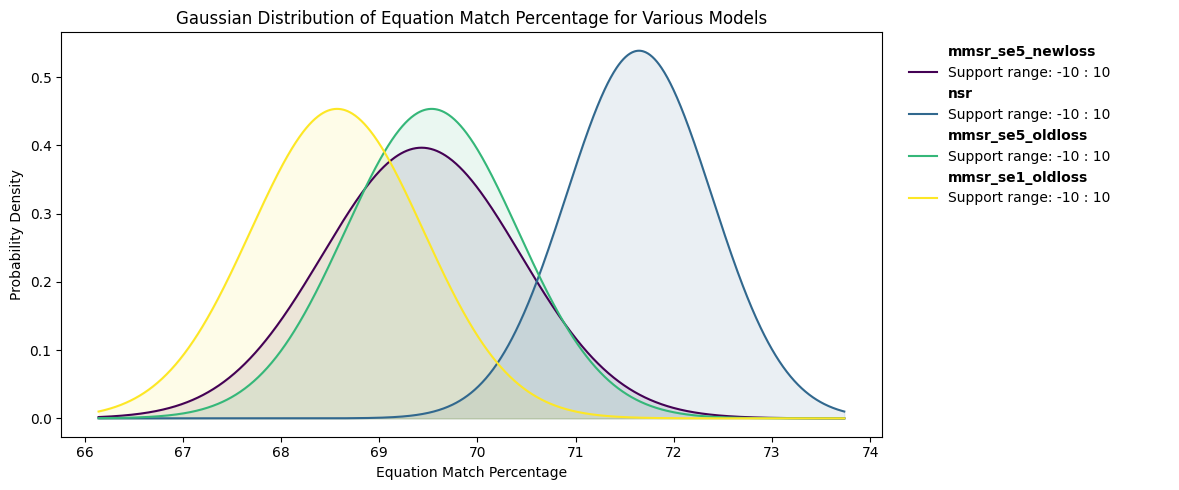

In [274]:
#TO DELETE
all_models = pd.read_csv('temp2.csv')

fig = plot_gaussian_distribution_multiple_models(all_models[all_models['Minimum Support'] == -10])
fig.show()

In [275]:
mmsr_newloss_eval = evaluation_summary[evaluation_summary['Model'] == 'mmsr_se5_oldloss']
mmsr_newloss_eval.head()

,Model,Dataset,Skeleton Encoder Layers,Loss Version,Minimum Support,Maximum Support,Total Entries,Match Sum,Match Percentage
335,mmsr_se5_oldloss,train_nc,5.0,old,-10,10,279,194,69.53405
336,mmsr_se5_oldloss,train_nc,NaN,old,-10,10,279,194,69.53405


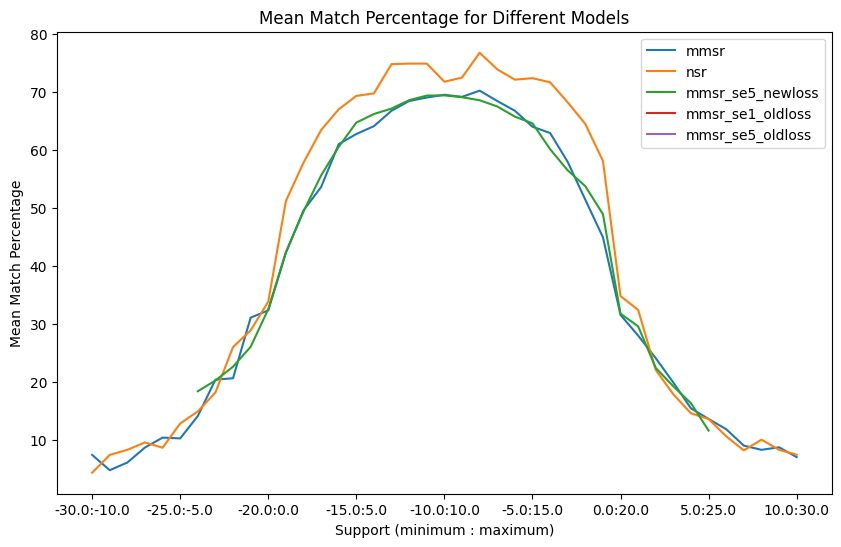

In [276]:
fig = plot_mean_match_percentage(evaluation_summary)
fig.show()

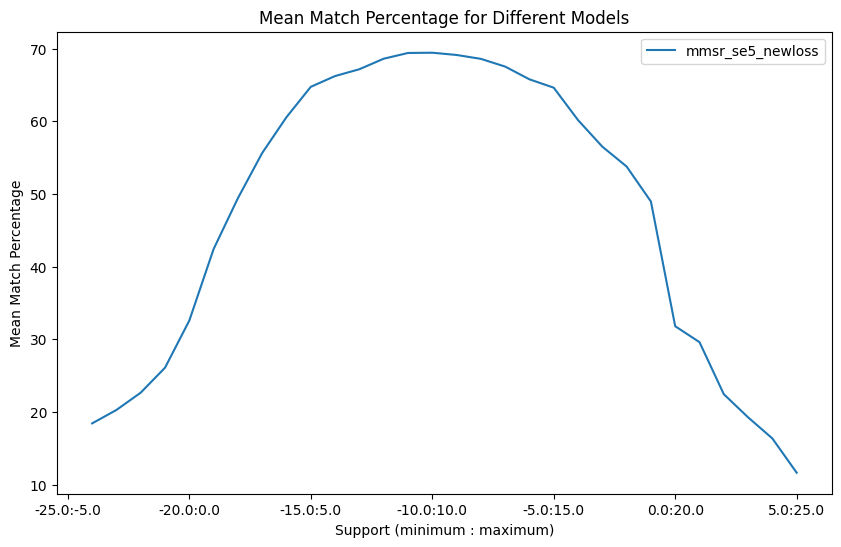

In [277]:
fig = plot_mean_match_percentage(evaluation_summary[evaluation_summary['Model'] == 'mmsr_se5_newloss'])
fig.show()

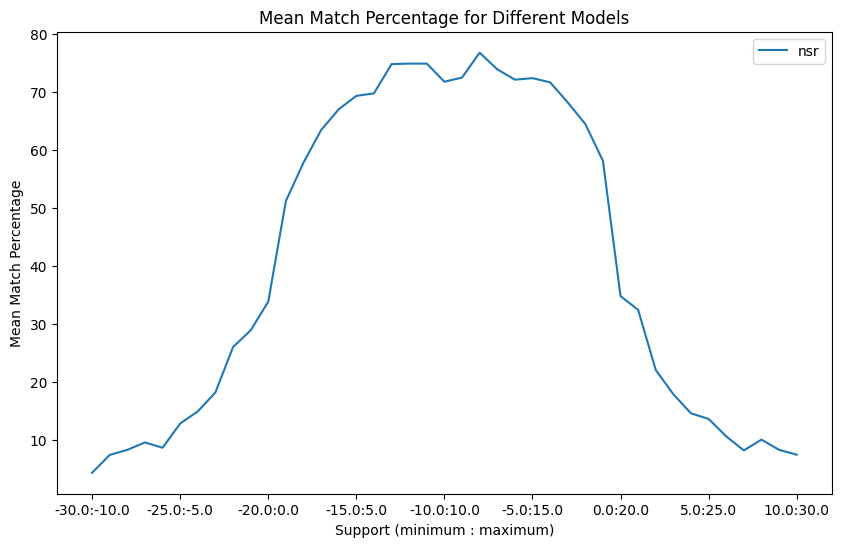

In [278]:
fig = plot_mean_match_percentage(evaluation_summary[evaluation_summary['Model'] == 'nsr'])
fig.show()